# Proyecto Final
## Andrés de Jesús Gonzalez Melgar - 20004118
## Jorge Anibal Velasquez Folgar - 11003655

In [1]:
# ! pip install scikeras[tensorflow]

# IMPORTANTE:

# USAR LAS SIGUIENTES VERSIONES
# scikit-learn: 1.5.2
# scikeras: 0.13.0

### EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
import math
import matplotlib.dates as mdates
# PIPELINE 
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
# MODELOS
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
# REDES NEURONALES
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

In [ ]:
dataset = pd.read_csv('SalesData.csv')
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
TARGET_VARIABLE = 'Weekly_Sales'

#### Gráficas de Densidad

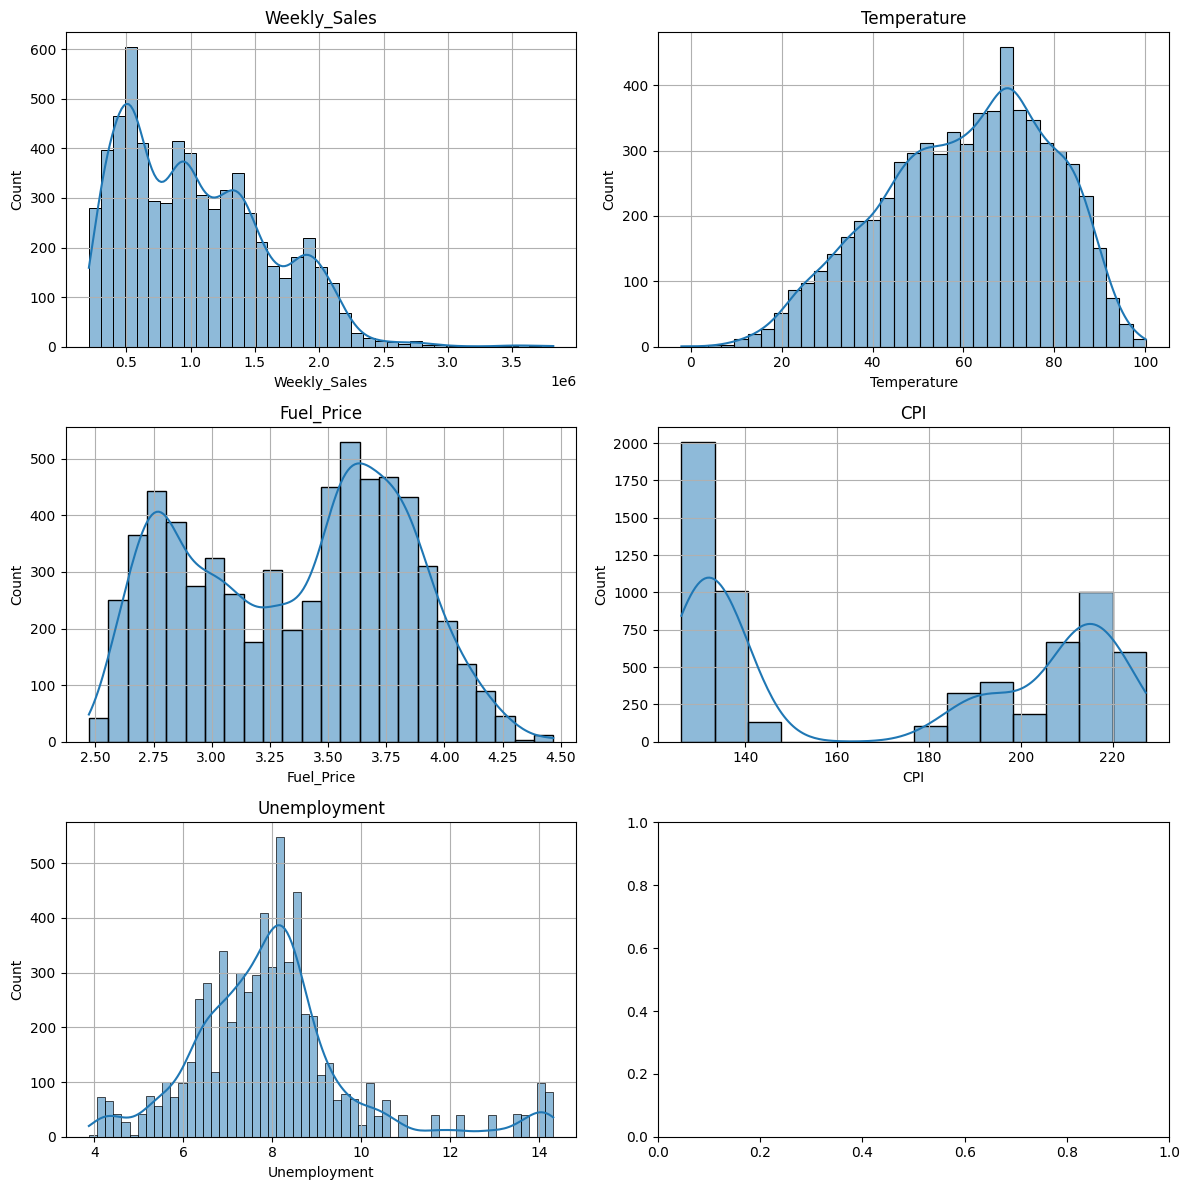

In [5]:
DENSITY_VARIABLES_TO_PLOT = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]

cols = 2
rows = math.ceil(len(DENSITY_VARIABLES_TO_PLOT) / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6 * cols, 4 * rows))

axes = axes.flatten()

for i, col in enumerate(DENSITY_VARIABLES_TO_PLOT):
    sns.histplot(data=dataset, x=col, ax=axes[i], kde=True)
    axes[i].set_title(col)
    axes[i].grid(True)


plt.tight_layout()
plt.show()

### Comentario:

<p> En las gráficas de densidad podemos observar el panorama general de las muestras realizadas en las diferentes ubicaciones de la empresa "X". Gracias a estas gráficas podemos visualizar detalles como el comportamiento casi normal de la temperatura, con una moda de 70 F. También notamos que existirá necesidad de eliminar outliers en los datos de ventas semanales y desempleo. Por otro lado, al observar el precio del combustible se notan alrededor de 2.75  y  3.60, los cuales pertenezcan a dos periodos de tiempo en los que los precios permanecieron estables en esos valores.</p>

<p> Al analizar el índice de precios observamos dos picos muy marcados, probablemente pertenecientes a dos periodos diferentes o diferentes areas geográficas, por lo que es de vital importancia analizar su relación con las variables Date y Store. El desempleo también puede variar con respecto a la ubicación o el tiempo, por lo que se debe de analizar su relación con el resto de variables.</p>

#### Gráfica de barras

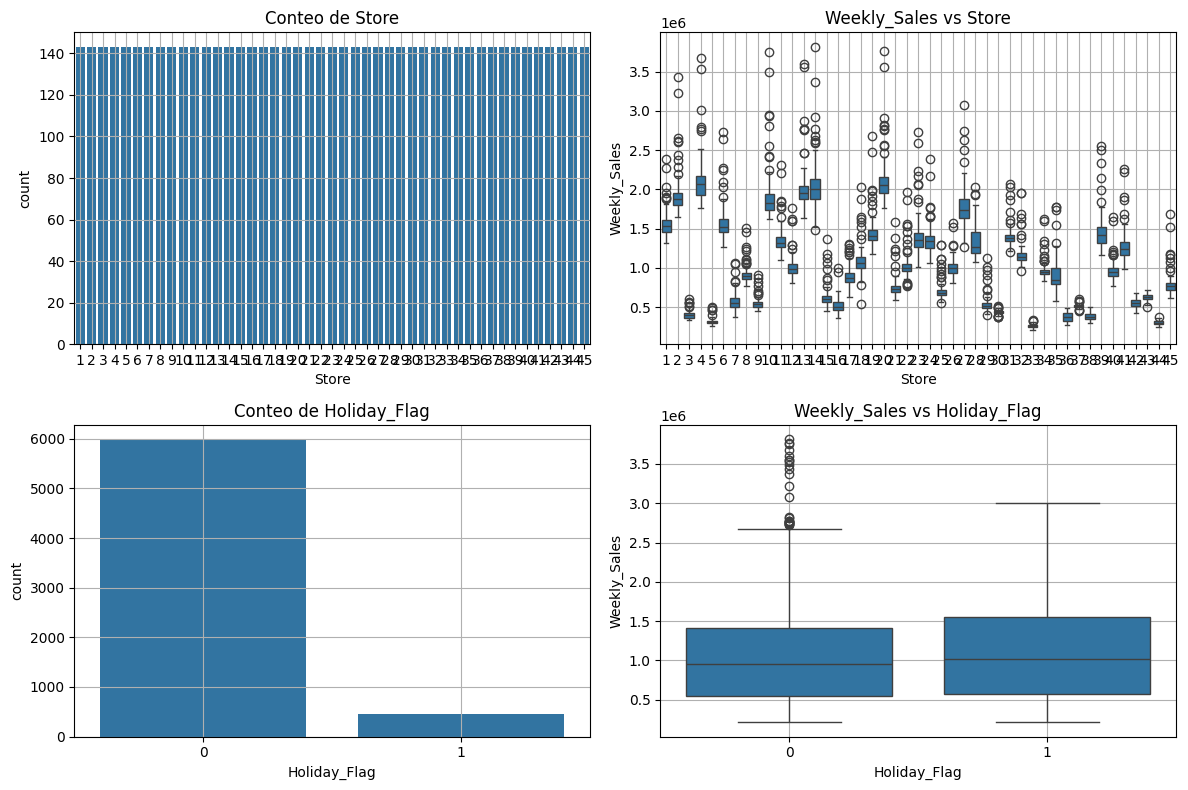

In [6]:
FREQUENCY_VARIABLES_TO_PLOT = ['Store', 'Holiday_Flag']
cols = 2
rows = len(FREQUENCY_VARIABLES_TO_PLOT)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6 * cols, 4 * rows))

for i, col in enumerate(FREQUENCY_VARIABLES_TO_PLOT):
    sns.countplot(data=dataset, x=col, ax=axes[i][0])
    axes[i][0].set_title(f'Conteo de {col}')
    axes[i][0].grid(True)

    sns.boxplot(data=dataset, x=col, y=TARGET_VARIABLE, ax=axes[i][1])
    axes[i][1].set_title(f'{TARGET_VARIABLE} vs {col}')
    axes[i][1].grid(True)

plt.tight_layout()
plt.show()


##### Comentario:

<p> Al observar las Box Plot notamos que, aunque las ventas por tienda pueden variar entre alrededor de los 300,000 y los 2 millones, las ventas se ven distribuidas uniformemente entre ellas. Por otro lado, la Box Plot de los días feriados nos muestra que, a excepción de algunos valores, la diferencia de ventas comparados con los días laborales no es significativa. </p>

### Gráfica de serie temporal

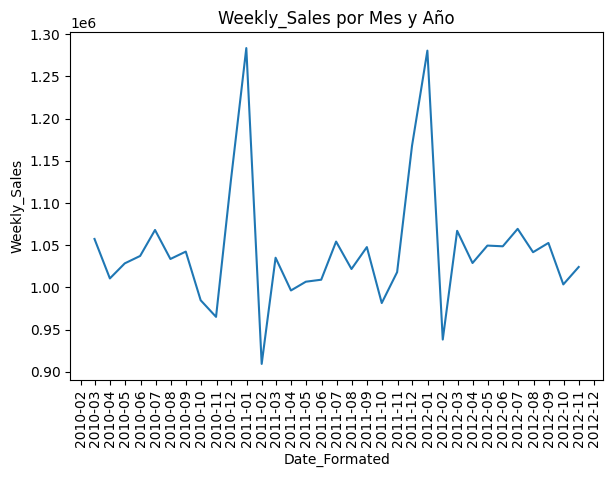

In [7]:
dataset['Date_Formated'] = pd.to_datetime(dataset['Date'], format="%d-%m-%Y")
dataset_grouped = dataset.groupby(pd.Grouper(key='Date_Formated', freq='ME'))[TARGET_VARIABLE].mean().reset_index()

sns.lineplot(data=
dataset_grouped, x='Date_Formated', y=TARGET_VARIABLE)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(rotation=45)
plt.title(f'{TARGET_VARIABLE} por Mes y Año')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


### Matriz de correlación

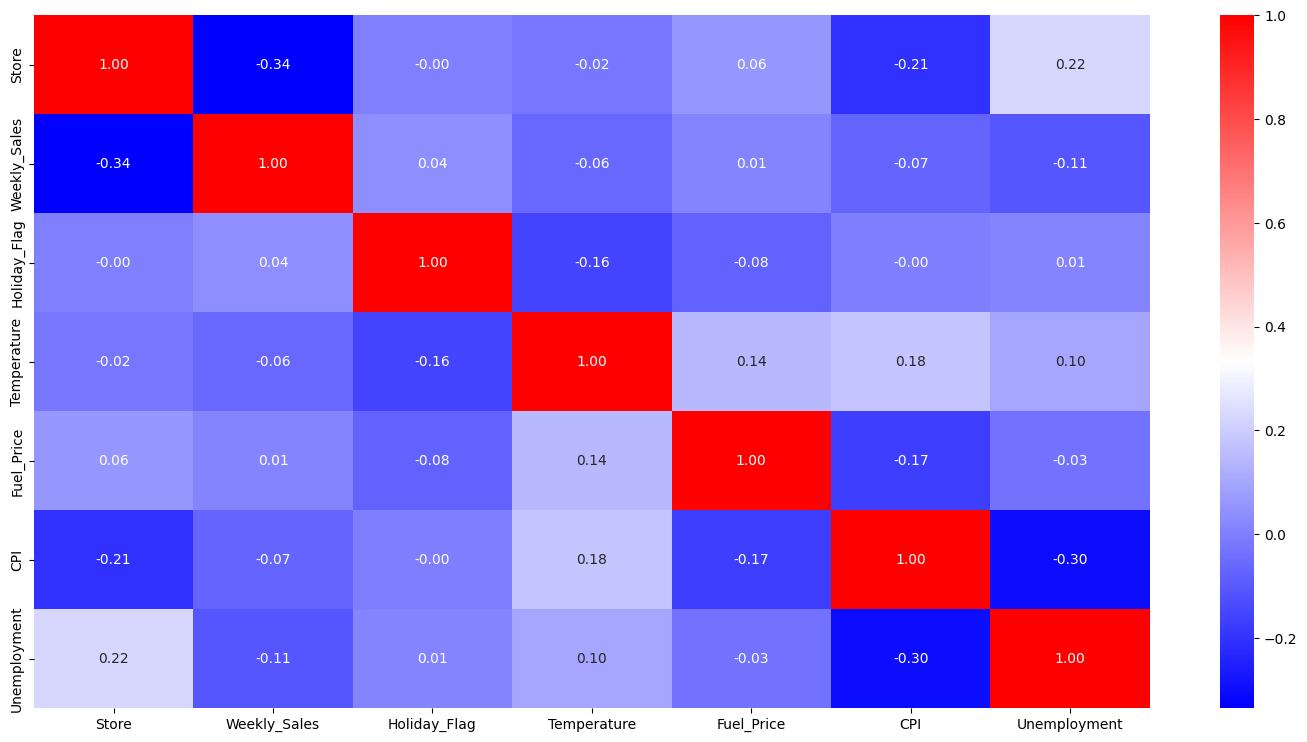

In [8]:
CATEGORICAL_VARIABLES = ['Date', 'Date_Formated']

tempDataSet = dataset
tempDataWithNoDate = tempDataSet.drop(labels=CATEGORICAL_VARIABLES, axis=1)

plt.figure(figsize=(18, 9))
sns.heatmap(data=tempDataWithNoDate.corr(), annot=True, fmt=".2f", cmap='bwr')
plt.show()

### Comentario general sobre el EDA:

<p> Además de las observaciones realizadas anteriormente cabe recalcar que la serie temporal muestra la subida de compras en los meses de noviembre y diciembre debido a las festividades de fin de año en USA. </p>

<p> Por otro lado, se observa que existe una correlación entre variables económicas como el CPI y el desempleo. Para ser mas exáctos, encontramos una relación inversa entre el índice de precios y el desempleo, lo cual parece ser consistente con la demanda baja a causa del desempleo, lo cual causa que los precios de mercado disminuyan. Aunque pareciera haber una relación marcada entre las tiendas con el CPI, el desempleo y las ventas semanales, el número de tienda podría ser simplemente un id, sin significado estadístico. De hecho, esta correlación parece contradecir al Box PLot analizado anteriormente, por lo que antes de sacar conclusiones de correlación, se debe de investigar si este id está relacionado con la ubicación de las tiendas o algún otro factor.</p>

<p> Finalmente, cabe destacar que no pareciera haber una relación muy marcada entre el desempleo y el CPI con la venta semanal. Una posible explicación es que la empresa "X" ofrece productos de primera necesidad a precios accesibles, los cuales son comprados aunque exista un índice alto de precios general o pocos empleos.</p>

## Ingeniería de características

#### Imputación variables cuantitativas

In [9]:
# NO HAY VALORES FALTANTES
dataset.isna().mean()

Store            0.0
Date             0.0
Weekly_Sales     0.0
Holiday_Flag     0.0
Temperature      0.0
Fuel_Price       0.0
CPI              0.0
Unemployment     0.0
Date_Formated    0.0
dtype: float64

#### Codificación variables categóricas

In [10]:
# Solamente hay 1 variable categórica de tipo fecha. Por lo tanto, crearé columnas
# Para guardar el año, mes y día de la fecha.

dataset['year'] = dataset['Date_Formated'].dt.year
dataset['month'] = dataset['Date_Formated'].dt.month
dataset['day'] = dataset['Date_Formated'].dt.day
dataset['dayofweek'] = dataset['Date_Formated'].dt.dayofweek
dataset['is_weekend'] = dataset['dayofweek'].isin([5,6]).astype(int)


dataset.drop(labels=CATEGORICAL_VARIABLES, axis=1, inplace=True)
dataset.drop(labels=['year'], axis=1, inplace=True)

dataset



,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,day,dayofweek,is_weekend
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2,5,4,0
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2,12,4,0
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2,19,4,0
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2,26,4,0
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,3,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,9,28,4,0
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,10,5,4,0
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,10,12,4,0
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,10,19,4,0


#### Tratamiento de Outliers y transformación

In [11]:
from sklearn.preprocessing import OneHotEncoder
### Pipeline
X = dataset.drop(columns=TARGET_VARIABLE)
y = dataset[TARGET_VARIABLE]

VARIABLES_TO_CAP_OUTLIER = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
PASSTHROUGH_COLUMNS = ['month', 'day', 'dayofweek', 'is_weekend', 'Holiday_Flag']
CATEGORICAL_COLUMNS = ['Store'] 
preprocessing = ColumnTransformer(transformers=[
    ('numeric', Pipeline([
        ('capping', Winsorizer(variables=VARIABLES_TO_CAP_OUTLIER, capping_method='iqr', tail='both')),
        ('scaler', StandardScaler())
    ]), VARIABLES_TO_CAP_OUTLIER),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_COLUMNS),
    ('passthrough', 'passthrough', PASSTHROUGH_COLUMNS)
])


#### Generación de .CSV de salida

In [ ]:
from sklearn.base import clone

# Crear copia segura del pipeline para exportar datos sin afectar el original
preprocessing_for_export = clone(preprocessing)

X_processed = preprocessing_for_export.fit_transform(X)
scaled_cols = VARIABLES_TO_CAP_OUTLIER

# Obtener nombres codificados
ohe = preprocessing_for_export.named_transformers_['categorical']
ohe_cols = list(ohe.get_feature_names_out(CATEGORICAL_COLUMNS))

# Unir todos los nombres
all_column_names = scaled_cols + ohe_cols + PASSTHROUGH_COLUMNS

# Crear DataFrame con columnas
X_processed_df = pd.DataFrame(X_processed, columns=all_column_names)

# Unir la variable objetivo
final_df = X_processed_df.copy()
final_df[TARGET_VARIABLE] = y.reset_index(drop=True)

final_df.to_csv("sales_data_procesado.csv", index=False)

### Implementación de Modelos

In [13]:
models = {
    'Regresión Lineal': {
        'model': LinearRegression(),
        'params': {
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {
            'model__kernel': ['rbf', 'linear'],
            'model__C': [0.1, 1, 10],
            'model__gamma': ['scale', 'auto'],
        }
    },
    'Árbol de Decisión': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
             'model__n_estimators': [50, 100, 200],
             'model__max_depth': [None, 20],
             'model__min_samples_split': [2, 5],
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5],
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]
        }
    }
}

In [14]:
from sklearn.model_selection import train_test_split

cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
results = []

# SPLIT DE LOS DATOS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('model', model['model'])    
    ])
    
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=model['params'],
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )
    
    # ENTRENAR USANDO LOS SEGMENTOS DEL SPLIT
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_rmse_train = -grid.best_score_
    std_rmse_train = grid.cv_results_['std_test_score'][grid.best_index_]
    
    # OBTENER RMSE
    y_pred_test = best_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    mean_y_test = y_test.mean()
    rmse_percent_test = (rmse_test / mean_y_test) * 100
    print('TERMINANDO ', name)
    results.append({
        'Modelo': name,
        'RMSE Promedio CV (Train)': best_rmse_train,
        'Desviación Std CV (Train)': std_rmse_train,
        'RMSE Test': rmse_test,
        'RMSE Test (%)': rmse_percent_test,
        'Mejores Hiperparámetros': grid.best_params_,
    })


TERMINANDO  Regresión Lineal
TERMINANDO  Support Vector Regression
TERMINANDO  Árbol de Decisión
TERMINANDO  Random Forest
TERMINANDO  Gradient Boosting
TERMINANDO  KNN


In [15]:
pd.DataFrame(results).sort_values(by='RMSE Test (%)', ascending=True).style.format({#reordenar
    'RMSE Promedio CV (Train)': '{:,.2f}',
    'Desviación Std CV (Train)': '{:,.2f}',
    'RMSE Test': '{:,.2f}',
    'RMSE Test (%)': '{:.2f}%',
})

,Modelo,RMSE Promedio CV (Train),Desviación Std CV (Train),RMSE Test,RMSE Test (%),Mejores Hiperparámetros
4,Gradient Boosting,"100,674.29","6,703.12","95,118.63",9.02%,"{'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}"
3,Random Forest,"129,188.74","11,396.06","127,866.06",12.12%,"{'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}"
2,Árbol de Decisión,"142,983.74","10,406.95","145,405.46",13.78%,"{'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}"
0,Regresión Lineal,"153,688.68","8,808.77","154,840.12",14.68%,{}
5,KNN,"503,359.51","9,692.24","518,078.15",49.11%,"{'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'uniform'}"
1,Support Vector Regression,"569,121.84","7,681.20","574,191.82",54.43%,"{'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'linear'}"


### Redes neuronales

In [16]:
from tensorflow.keras import Input

X_train_processed = preprocessing.fit_transform(X_train)
X_test_processed = preprocessing.transform(X_test)
input_dim = X_train_processed.shape[1]

def sequential_neural_network(n_hidden=1, n_neurons=5, learning_rate=0.01):
    model = Sequential()
    # INITIAL LAYER
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(n_neurons, activation='relu', kernel_initializer='uniform'))
    # HIDDEN LAYERS
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation='relu', kernel_initializer='uniform'))
    # OUTPUT LAYER
    model.add(Dense(units=1, kernel_initializer='uniform')) 
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mse'])
    return model

def sequential_nn_dropout(n_hidden=2, n_neurons=10, learning_rate=0.01, dropout_rate=0.3):
    model = Sequential()
    
    # INPUT
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(n_neurons, activation='relu', kernel_initializer='uniform'))
    model.add(Dropout(dropout_rate))
    
    # HIDDEN LAYERS
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation='relu', kernel_initializer='uniform'))
        model.add(Dropout(dropout_rate))
    
    # OUTPUT
    model.add(Dense(units=1, kernel_initializer='uniform'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return model

def sequential_nn_tanh(n_hidden=2, n_neurons=16, learning_rate=0.001):
    model = Sequential()

    # INPUT
    model.add(Dense(n_neurons, activation='tanh', input_shape=(input_dim,), kernel_initializer='glorot_uniform'))

    # HIDDEN LAYERS
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation='tanh', kernel_initializer='glorot_uniform'))

    # OUTPUT
    model.add(Dense(units=1, kernel_initializer='glorot_uniform'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return model

In [17]:
mlp_model = KerasRegressor(
    model=sequential_neural_network,
    verbose=0,
)

mlp_dropout_model = KerasRegressor(
    model=sequential_nn_dropout,
    verbose=0
)

mlp_tanh_model = KerasRegressor(
    model=sequential_nn_tanh,
    verbose=0
)

neural_network_models = {
    'MLP_1': {
        'model': mlp_model,
        'params': {
            'model__n_hidden': [3],
            'model__n_neurons': [3],
            'model__learning_rate': [0.1],
            'batch_size': [10],
            'epochs': [100]
        }
    },
    'MLP_Dropout_1': {
        'model': mlp_dropout_model,
        'params': {
            'model__n_hidden': [2],
            'model__n_neurons': [15],
            'model__learning_rate': [0.01],
            'model__dropout_rate': [0.3],
            'batch_size': [16],
            'epochs': [100]
        }
    },'MLP_2': {
        'model': mlp_model,
        'params': {
            'model__n_hidden': [2],
            'model__n_neurons': [5],
            'model__learning_rate': [0.1],
            'batch_size': [10],
            'epochs': [100]
        }
    },
    'MLP_Dropout_2': {
        'model': mlp_dropout_model,
        'params': {
            'model__n_hidden': [3],
            'model__n_neurons': [10],
            'model__learning_rate': [0.01],
            'model__dropout_rate': [0.3],  # este parámetro es nuevo
            'batch_size': [16],
            'epochs': [100]
        }
    },'MLP_3': {
        'model': mlp_model,
        'params': {
            'model__n_hidden': [4],
            'model__n_neurons': [6],
            'model__learning_rate': [0.01],
            'batch_size': [8],
            'epochs': [120]
        }
    },
    'MLP_Dropout_3': {
        'model': mlp_dropout_model,
        'params': {
            'model__n_hidden': [3],
            'model__n_neurons': [20],
            'model__learning_rate': [0.005],
            'model__dropout_rate': [0.4],
            'batch_size': [16],
            'epochs': [150]
        }
    }
}

In [18]:
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)


for name, model_info in neural_network_models.items():
    grid = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1 
    )
    
    grid.fit(X_train_processed, y_train)

    best_rmse = -grid.best_score_
    std_rmse = grid.cv_results_['std_test_score'][grid.best_index_]

    y_pred = grid.predict(X_test_processed)
    mean_y = y.mean()
    rmse_percent = (best_rmse / mean_y) * 100
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    print('TERMINANDO ', name)

    results.append({
        'Modelo': name,
        'RMSE Promedio CV (Train)': best_rmse,
        'Desviación Std CV (Train)': std_rmse,
        'RMSE Test': rmse_test,
        'RMSE Test (%)': rmse_percent,
        'Mejores Hiperparámetros': grid.best_params_,
    })

TERMINANDO  MLP_1
TERMINANDO  MLP_Dropout_1
TERMINANDO  MLP_2
TERMINANDO  MLP_Dropout_2
TERMINANDO  MLP_3
TERMINANDO  MLP_Dropout_3


In [20]:
df_results = pd.DataFrame(results).sort_values(by='RMSE Test (%)', ascending=True).reset_index(drop=True)

tags = ['Champion'] + ['Challenger'] * 3 + ['Deprecated'] * (len(df_results) - 4)
df_results['Tag'] = tags

df_results = df_results.style.format({
    'RMSE Promedio CV (Train)': '{:,.2f}',
    'Desviación Std CV (Train)': '{:,.2f}',
    'RMSE Test': '{:,.2f}',
    'RMSE Test (%)': '{:.2f}%',
})

df_results.to_csv("resultados_modelos.csv", index=False)

df_results

,Modelo,RMSE Promedio CV (Train),Desviación Std CV (Train),RMSE Test,RMSE Test (%),Mejores Hiperparámetros,Tag
0,Gradient Boosting,"100,674.29","6,703.12","95,118.63",9.02%,"{'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}",Champion
1,Random Forest,"129,188.74","11,396.06","127,866.06",12.12%,"{'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}",Challenger
2,Árbol de Decisión,"142,983.74","10,406.95","145,405.46",13.78%,"{'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}",Challenger
3,MLP_3,"151,184.99","6,459.81","155,131.30",14.44%,"{'batch_size': 8, 'epochs': 120, 'model__learning_rate': 0.01, 'model__n_hidden': 4, 'model__n_neurons': 6}",Challenger
4,Regresión Lineal,"153,688.68","8,808.77","154,840.12",14.68%,{},Deprecated
5,MLP_Dropout_1,"171,726.58","15,132.13","193,956.41",16.40%,"{'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.01, 'model__n_hidden': 2, 'model__n_neurons': 15}",Deprecated
6,MLP_Dropout_3,"197,332.04","11,199.02","202,140.18",18.85%,"{'batch_size': 16, 'epochs': 150, 'model__dropout_rate': 0.4, 'model__learning_rate': 0.005, 'model__n_hidden': 3, 'model__n_neurons': 20}",Deprecated
7,MLP_Dropout_2,"236,063.01","26,067.86","253,754.92",22.55%,"{'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.01, 'model__n_hidden': 3, 'model__n_neurons': 10}",Deprecated
8,MLP_2,"501,466.65","485,953.16","155,116.35",47.90%,"{'batch_size': 10, 'epochs': 100, 'model__learning_rate': 0.1, 'model__n_hidden': 2, 'model__n_neurons': 5}",Deprecated
9,MLP_1,"502,832.26","480,106.17","158,916.57",48.03%,"{'batch_size': 10, 'epochs': 100, 'model__learning_rate': 0.1, 'model__n_hidden': 3, 'model__n_neurons': 3}",Deprecated


### Análisis de modelos y conclusiones

<p>Como podemos observar, el mejor rendimiento en test lo podemos observar en los resultados del modelo Gradient Boosting. Al tener el Error Absoluto Medio Cuadrático Test más bajo es el que provee mejores resultados. Su Desviación es de las más bajas de los modelos evaluados por lo que su estabilidad es de las mejores. Entre sus desventajas podemos mencionar que es menos eficiente y simple en comparación con otros modelos como el Random Forest, además de que es muy sensible a sus hipoerparámetros, por lo que requiere múltiples pruebas para encontrar su mejor rendimiento. Al realizar múltiples pruebas con diferentes parámetros se encontró uno que brinda excelentes resultados sin evidencia de estar sobreajustado (debido a su RMSE bajo). Por lo anterior, se clasifica al Random Forest con el tag <b>Champion</b>. </p>

<p>Seguido del Gradient Boosting encontramos a los modelos de Árbol de Decisión, Random Forest y la tercera configuración de la red neuronal MLP. Los modelos Random Forest y Árbol de decisión, aunque brindaron una desviación mayor, se siguen considerando como estables al compararlas con las cifras millonarias de las ventas semanales. Estos modelos son bastante mas simples, explicativos y requieren de menos poder computacional para ser ejecutados que el Gradient Boosting, sin sacrificar demasiado su precisión de 12.12% y 13.78% de error, por lo que dependiendo de la situación y la precisión requerida, podrían ser utilizados en lugar de el Gradient Boosting.</p>
    
<p>Al analizar los parámetros del mejor MLP (Perceptrón Multicapa) observamos cómo al aumentar la cantidad de neuronas utilizadas disminuye significativamente el RMSE. Sin embargo, esto implica un aumento significativo del poder computacional requerido, llegando a ser muy superior que el de los modelos mencionados anteriormente. Ajustando aún mas sus parámetros podríamos aumentar su precisión, pero se debe de tener cuidado, no solo con el aumento de recursos requeridos, sino con que esta red tiende a sobreajustarse al no asumir una forma funcional concreta (no paramétrica). De hecho, tanto en este modelo como en el de Árbol de Decisión podemos observar cómo aumenta el RMSE Test en comparación con el RMSE del entrenamiento, pudiendo ser indicio de un sobeajuste.</p>

<p>A pesar de sus contras, el bajo RMSE% y Desviación Estandar de los modelos, Random Forest, Árbol de Decisión y la mejor configuración de MLP son etiquetados como modelos <b>Challenger.</p>

<p>El resto de modelos han sido etiquetados como <b>Deprecated</b> debido a su bajo rendimiento o poca estabilidad. Entre estos cabe destcar el modelo de Regresión Lineal (RL), ya que aunque es el modelo más simple, eficiente y tiene una precisión y estabilidad similar a la de los modelos Challenger, su poca flexibilidad no permite que sea configurado para mejorar significativamente sus resultados. Debido a lo anterior y a su posición en la tabla, la RL fue elegida com límite entre los modelos Challenger y Deprecated.</p>
    
<p>Analizando el resto de los modelos de redes neuronales, observamos que a pesar de tener una mayor cantidad de neuronas internas (30 y 60) que los MLP simples (24, 10 y 9), los modelos MLP Dropout no mejoran su rendimiento. Esto es debido a que los Dropout sacrifican eficiencia y precisión para evitar el sobreajuste que caracteriza a un MLP, desactivando neuronas al azar ajustado por el parámetro model__dropout_rate. También vemos cómo al otorgar pocos recursos a los modelos MLP, sus métricas RMSE son muy altas.</p>

<p>Finalmente, los modelos KNN y SVR son los que mayores errores medios presentan, además de ser más complejos que los mejores 3, por lo que son descartados por completo.</p>

<p>Como comentario final es importante recordar que se deben realizar entrenamientos y pruebas acordes al poder computacional que se utilizará en producción, ya que ésta posee mas recurso computacional podrían existir parámetros que brinden mejores resultados y mantener una velocidad adecuada, sin mencionar que podríamos probar con una gama más amplia d combinaciones. Por el contrario, si la máquina objetivo tiene menos capacidades, el modelo Champión podría ser ineficiente.</p>